# SOLO and FPN (Instance Segmentation)


## Code Structure
This notebook makes use of the following helper files:
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [5]:
try:
    import dataset
    import model
    import visualize
    import train
    import inference
except ModuleNotFoundError:
    print("Module not found.")
    pass

In [6]:
!pip install pytorch_lightning &> /dev/null
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import matplotlib.patches as patches
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import transforms
import h5py  
from torch.utils.data import Subset
from dataset import SOLODataset
import torch.nn.functional as F
from importlib import reload
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [7]:
reload(dataset)
reload(model)
reload(visualize)
reload(train)
reload(inference)

<module 'inference' from '/content/inference.py'>

### Mounting Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, we implement an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this. 

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [9]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
# def collate_fn(batch):
#     images, labels, masks, bounding_boxes = list(zip(*batch))
#     return torch.stack(images), labels, masks, bounding_boxes

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.
 
#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

## Visualizations

Run instructions:
1. Upload ```dataset.py```,```model.py``` and ```visualize.py``` in the local runtime environment directory.
2. Mount Google Drive as done above in the notebook by running all the cells above.
3. Specify the path of the folder containing all the data in the variable ```folder_path```.
4. Execute the 4 following cells. (Select batch size by modifying ```batch_size```. (Warning: A batch size > 8 causes out of memory issues while plotting target visualizations.) 
5. In the third cell modify the value of ```idx``` to see the visualization for different batches. 


### Creating dataloader

In [10]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW3/SOLO_data/"
bboxes_file = "hw3_mycocodata_bboxes_comp_zlib.npy"
images_file = "hw3_mycocodata_img_comp_zlib.h5"
labels_file = "hw3_mycocodata_labels_comp_zlib.npy"
mask_file = "hw3_mycocodata_mask_comp_zlib.h5"


bboxes = dataset.load_data_np(folder_path + bboxes_file)
labels = dataset.load_data_np(folder_path + labels_file)
images = dataset.load_data_h5py(folder_path + images_file).astype("uint8").transpose((0,2,3,1))
masks = dataset.load_data_h5py(folder_path + mask_file).astype("int8")
masks = np.expand_dims(masks,-1)
masks_unflattened = dataset.unflatten_masks(masks=masks, bboxes=bboxes)

In [11]:
train_percentage = .8
train_count=int(len(images) * train_percentage )

batch_size = 8



train_dataset = SOLODataset(tensors=(images[:train_count], bboxes[:train_count], labels[:train_count], masks_unflattened[:train_count]))
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=dataset.collate_fn) 

val_dataset = SOLODataset(tensors=(images[train_count:], bboxes[train_count:], labels[train_count:], masks_unflattened[train_count:]))
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=dataset.collate_fn) 


In [23]:
idx=10
i=0
for image, label, mask, bbox in train_loader:
    # print(x)
    if i==idx:
      break
    i+=1


The visualizations for all the images in the batch are plotted as below. The color coding for bounding boxes and masks is as follows:
- Red : Animal
- Blue : Vehicle
- Green : Person

The pre-plotted images contain objects from different classes, scales as well as objects from different classes in the same image.

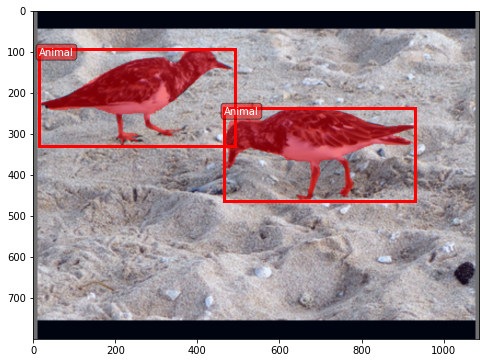

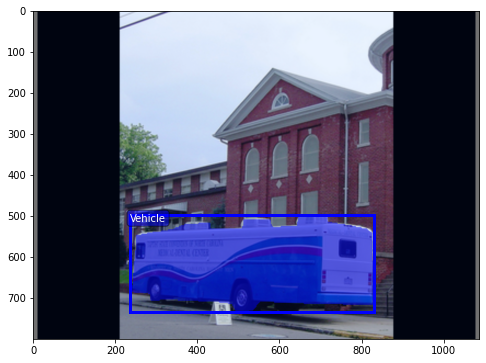

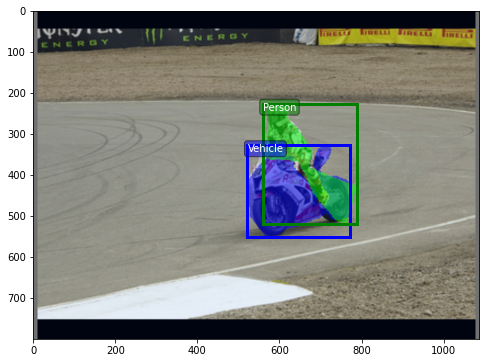

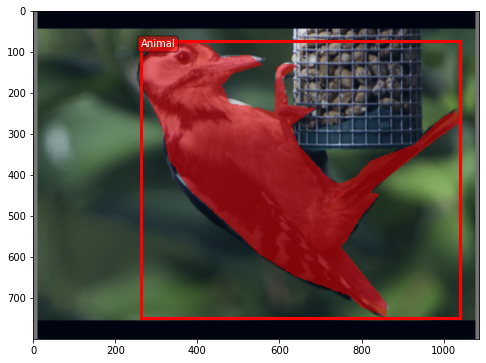

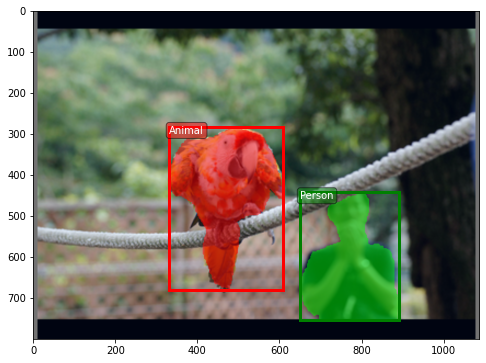

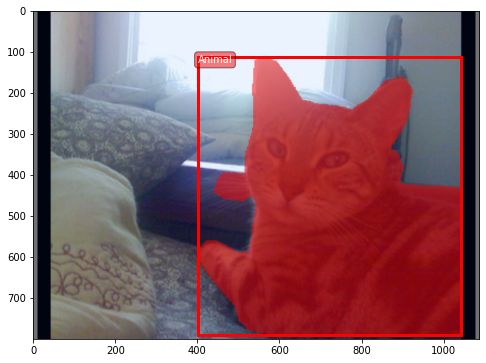

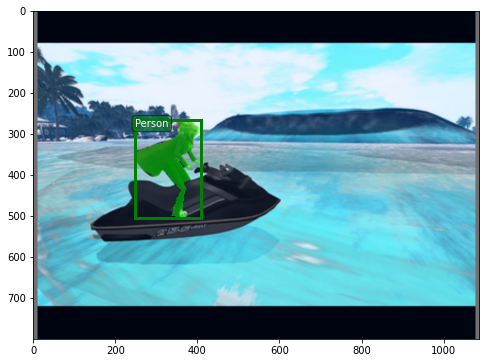

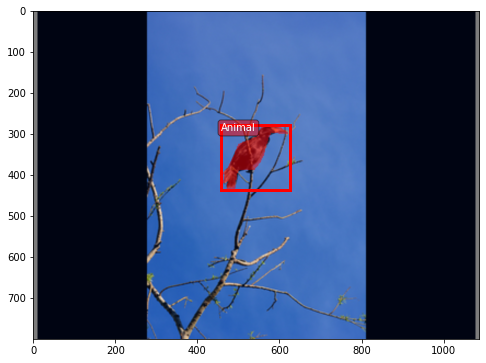

In [24]:
for idx in range(len(image)):
  plot_image = dataset.normalize_np_array_for_plotting(image[idx].permute((1,2,0)).numpy())
  masked_image = dataset.apply_mask_to_image(plot_image,mask[idx],label[idx], alpha=0.5)
  dataset.plot_image_with_boxes(masked_image,label[idx],bbox[idx])

## Target Visualizations

Run instructions:
1. Run all the cells above including all the cells for visualization of original images.
2. Run the cell below for getting visualization for different fpn levels and the detection by them for images of different classes and scales.

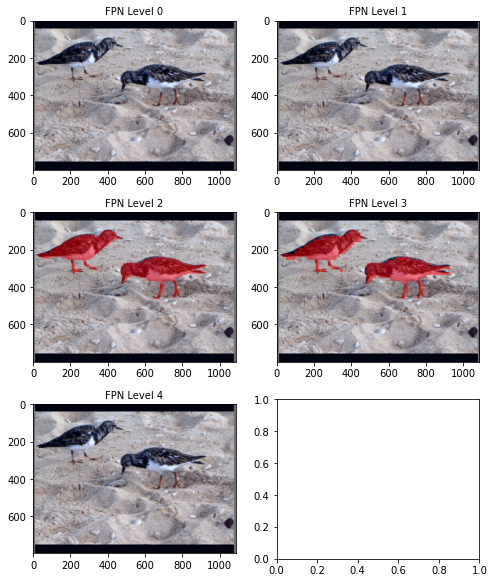

----------------------------------------------------------------------------------------------------


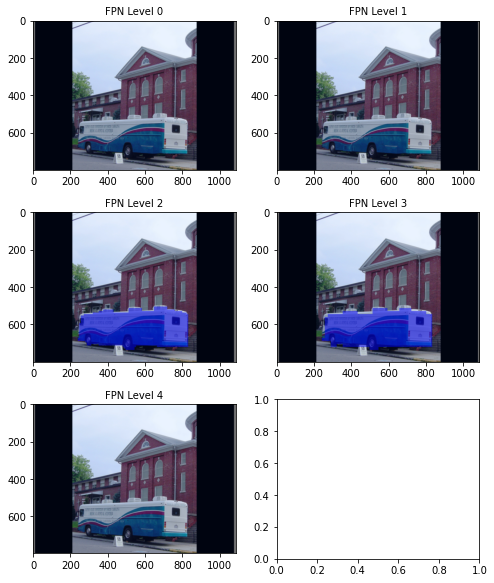

----------------------------------------------------------------------------------------------------


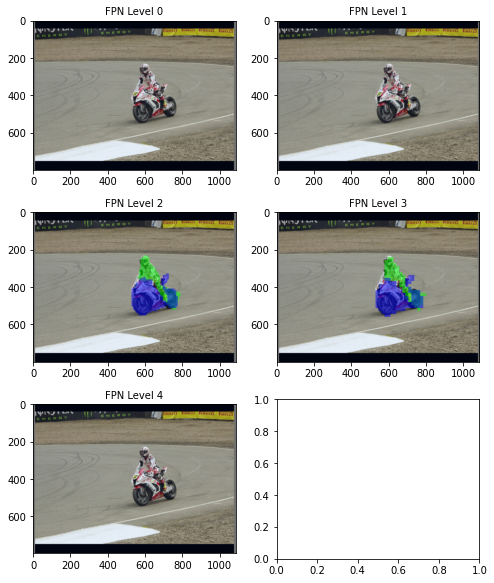

----------------------------------------------------------------------------------------------------


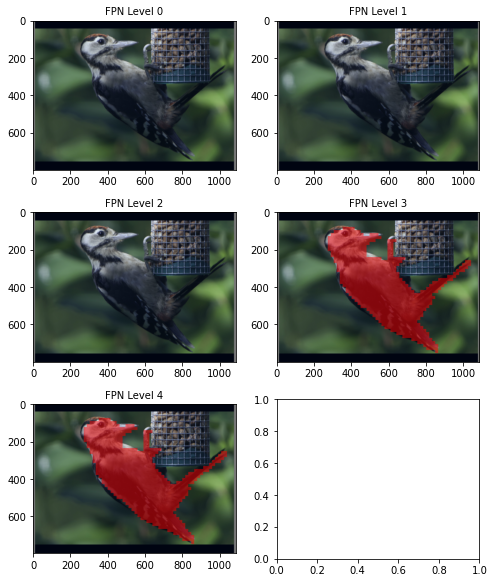

----------------------------------------------------------------------------------------------------


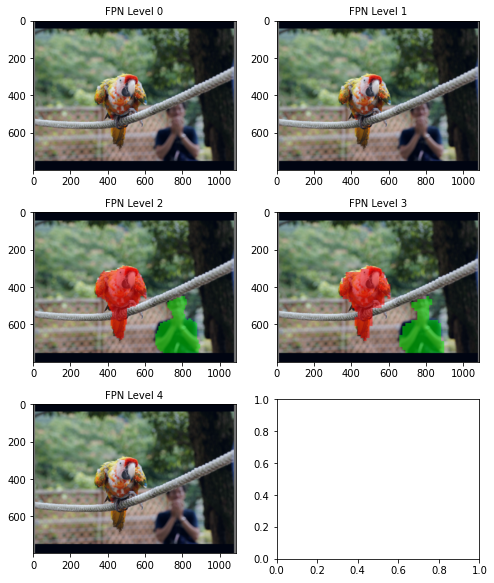

----------------------------------------------------------------------------------------------------


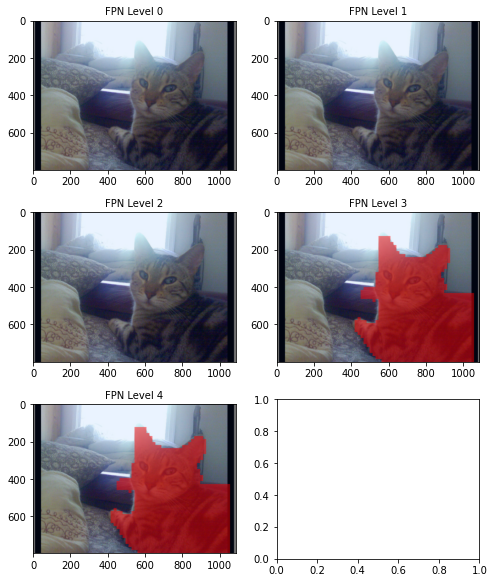

----------------------------------------------------------------------------------------------------


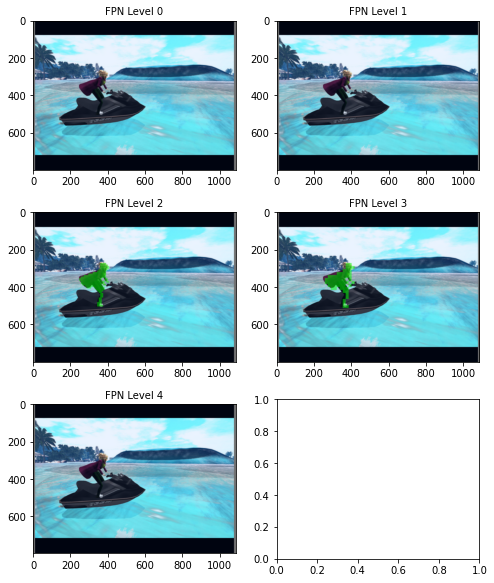

----------------------------------------------------------------------------------------------------


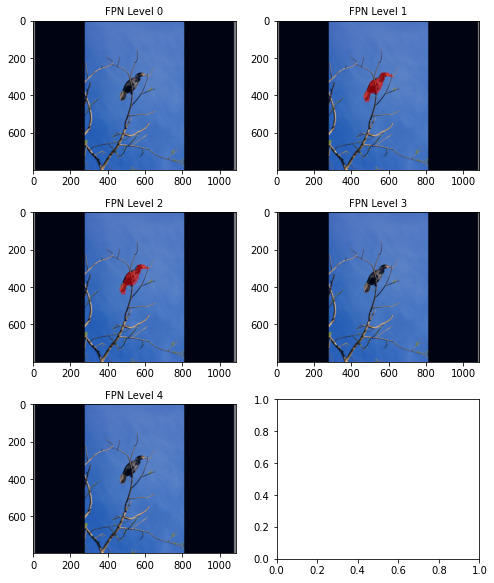

----------------------------------------------------------------------------------------------------


In [25]:
SOLO_model = model.SOLO()
target_categ, target_mask,target_activation = SOLO_model.generate_targets(bounding_boxes = bbox, labels=label, masks=mask)

for image_idx in range(len(target_categ)):
    target_categ_fpn = target_categ[image_idx]
    target_mask_fpn = target_mask[image_idx]
    target_activation_fpn = target_activation[image_idx]

    visualize.generate_fpn_mask_plots(image, image_idx, target_categ_fpn, target_mask_fpn, target_activation_fpn)
    print("-"*100)

del target_categ
del target_mask, target_activation

## Model Forward - Eval = True and Eval = False

The following cells call the forward function of the model with eval flags ```True``` and ```False``` and print out the dimensions of the respective fpn levels.

In [ ]:
modelSOLO = model.SOLO()
categ_batch,mask_batch = modelSOLO.forward(image, eval=False)
print("Eval = False")
for x,y in zip(categ_batch, mask_batch):
    print("Categ:",x.shape,"| Mask:", y.shape)

del categ_batch, mask_batch

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Eval = False
Categ: torch.Size([4, 3, 40, 40]) | Mask: torch.Size([4, 1600, 200, 272])
Categ: torch.Size([4, 3, 36, 36]) | Mask: torch.Size([4, 1296, 200, 272])
Categ: torch.Size([4, 3, 24, 24]) | Mask: torch.Size([4, 576, 100, 136])
Categ: torch.Size([4, 3, 16, 16]) | Mask: torch.Size([4, 256, 50, 68])
Categ: torch.Size([4, 3, 12, 12]) | Mask: torch.Size([4, 144, 50, 68])


In [ ]:
modelSOLO = model.SOLO()
categ_batch,mask_batch = modelSOLO.forward(image, eval=False)
print("Eval = False")
for x,y in zip(categ_batch, mask_batch):
    print("Categ:",x.shape,"| Mask:", y.shape)

del categ_batch, mask_batch

Eval = False
Categ: torch.Size([4, 3, 40, 40]) | Mask: torch.Size([4, 1600, 200, 272])
Categ: torch.Size([4, 3, 36, 36]) | Mask: torch.Size([4, 1296, 200, 272])
Categ: torch.Size([4, 3, 24, 24]) | Mask: torch.Size([4, 576, 100, 136])
Categ: torch.Size([4, 3, 16, 16]) | Mask: torch.Size([4, 256, 50, 68])
Categ: torch.Size([4, 3, 12, 12]) | Mask: torch.Size([4, 144, 50, 68])


## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

In [ ]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

### Training model 

In [ ]:
!nvidia-smi

Mon Oct 24 20:21:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor
reload(train)
reload(model)
solo_trainer = train.SOLOTrainer(batch_size=batch_size).to(device)

save_dir = "/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW3/SOLO_logs_temp" #TODO: CHANGE Logging directory
checkpoint_callback = pl_callbacks.ModelCheckpoint()
lr_monitor = LearningRateMonitor(logging_interval='epoch')
tb_logger = pl_loggers.TensorBoardLogger(save_dir = save_dir)

# checkpoint_save_dir = ""
trainer = pl.Trainer(gpus=-1,accelerator="gpu",logger=tb_logger, max_epochs=36, callbacks=[checkpoint_callback, lr_monitor])
trainer.fit(solo_trainer, train_loader, val_loader)#, ckpt_path="/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW3/SOLO_logs2/lightning_logs/version_3/checkpoints/epoch=18-step=13965.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name         | Type            | Params
--------------------------------------------------
0  | backbone     | BackboneWithFPN | 26.8 M
1  | conv1_c      | Sequential      | 590 K 
2  | conv2_c      | Sequential      | 590 K 
3  | conv3_c      | Sequential      | 590 K 
4  | conv4_c      | Sequential      | 590 K 
5  | conv5_c      | Sequential      | 590 K 
6  | conv6_c      | Sequential      | 590 K 
7  | conv7_c      | Sequential      | 590 K 
8  | conv_out_c   | Sequential      | 6.9 K 
9  | categ_branch | Sequential      | 4.1 M 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=36` reached.


## Training Losses Plots

In [ ]:
visualizations_save_path = "/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW3/Plots/"

### Dice Loss


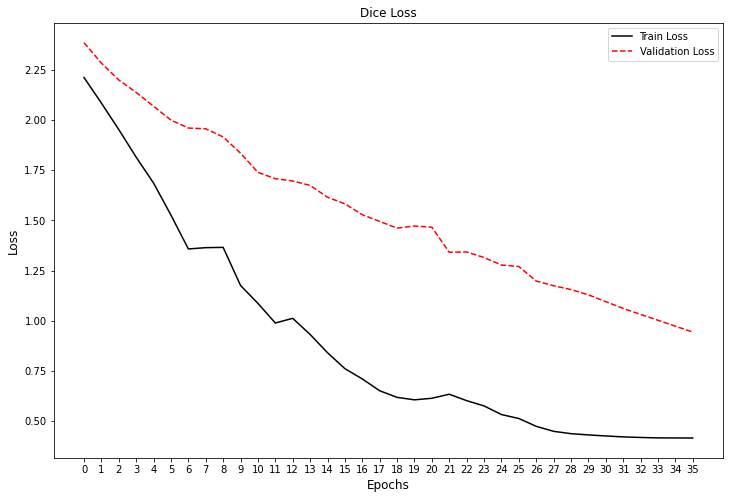

In [ ]:
# title = "Dice Loss"
# values1 = solo_trainer.dice_loss_epoch
# label1 = "Train Loss"
# values2 = solo_trainer.dice_loss_epoch_val[1:]
# label2 = "Validation Loss"
# visualize.plot_training_losses(values1, label1, title, values2, label2) #, save_path=visualizations_save_path)

### Focal Loss

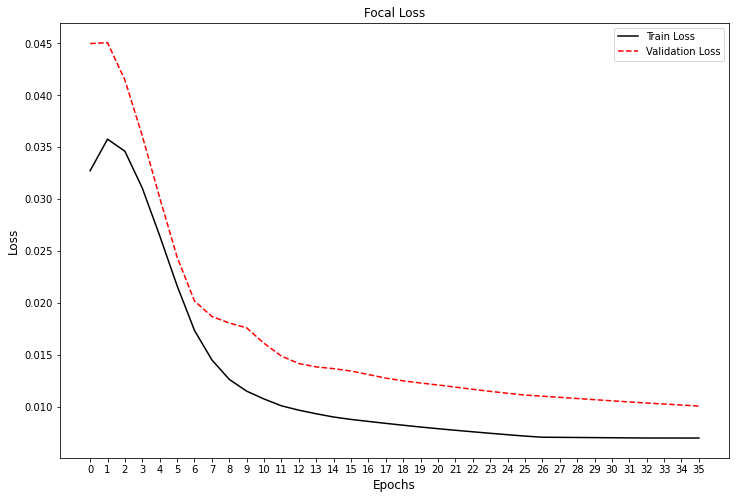

In [ ]:
# title = "Focal Loss"
# values1 = solo_trainer.focal_loss_epoch
# label1 = "Train Loss"
# values2 = solo_trainer.focal_loss_epoch_val[1:]
# label2 = "Validation Loss"
# visualize.plot_training_losses(values1, label1, title, values2, label2)#, save_path=visualizations_save_path)

### Total Training Losses 

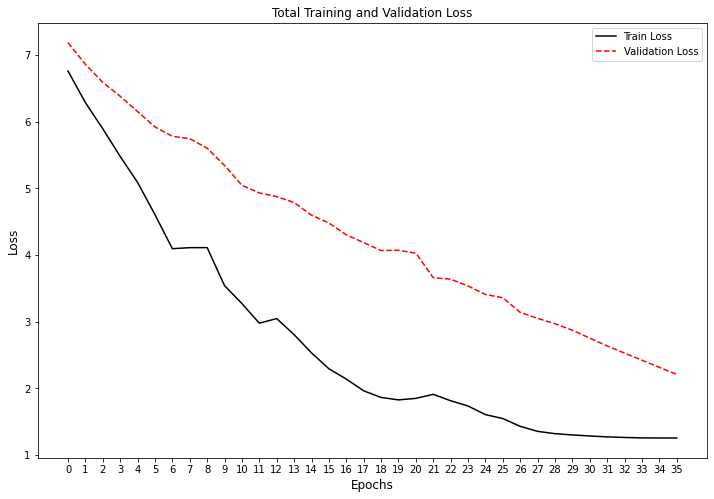

In [ ]:
# title = "Total Training and Validation Loss"
# values1 = solo_trainer.train_losses_epoch
# label1 = "Train Loss"
# values2 = solo_trainer.val_losses_epoch[1:]
# label2 = "Validation Loss"
# visualize.plot_training_losses(values1, label1, title, values2, label2)#, save_path=visualizations_save_path)

## Post-Processing Results & Plotting Result Visualizations

Execute the cells below to plot the visualization of results after post-processsing.

#### Loading model checkpoint

In [ ]:
%%capture
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW3/SOLO_logs2/lightning_logs/version_4/checkpoints/epoch=35-step=26460.ckpt"
SOLO_model_ckpt = train.SOLOTrainer().load_from_checkpoint(checkpoint_path)
SOLO_model_ckpt.eval()

#### Generating dataset containing images from different classes

In [ ]:
image_samples = [4,5,6,12,16,17,21,25,27,33, 38, 44, 48, 69, 71, 55, 58, 59 ]
# len(image_samples)

18

0


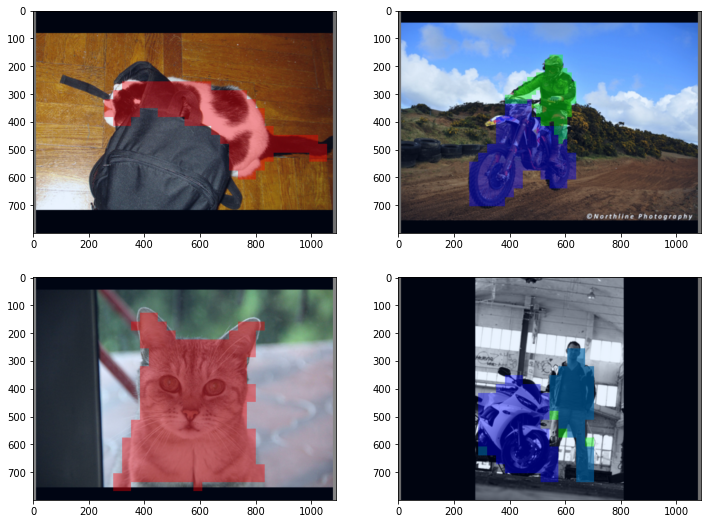

1


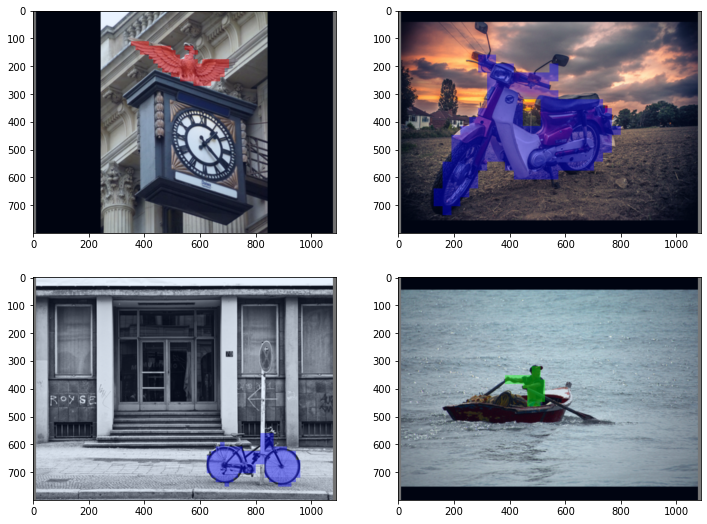

2


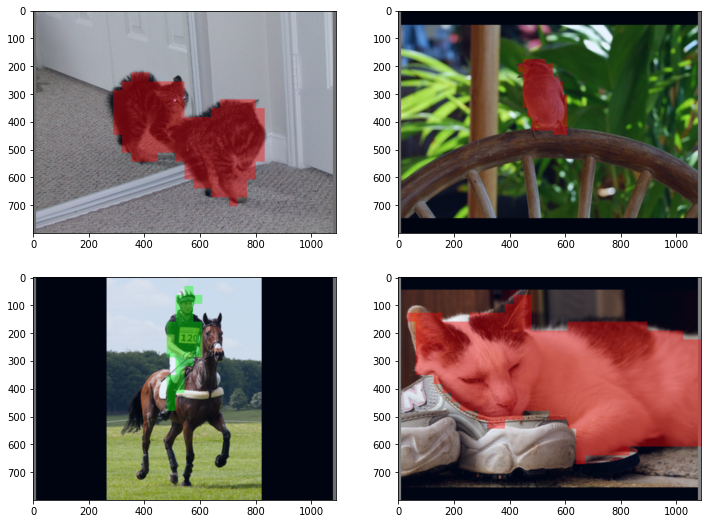

3


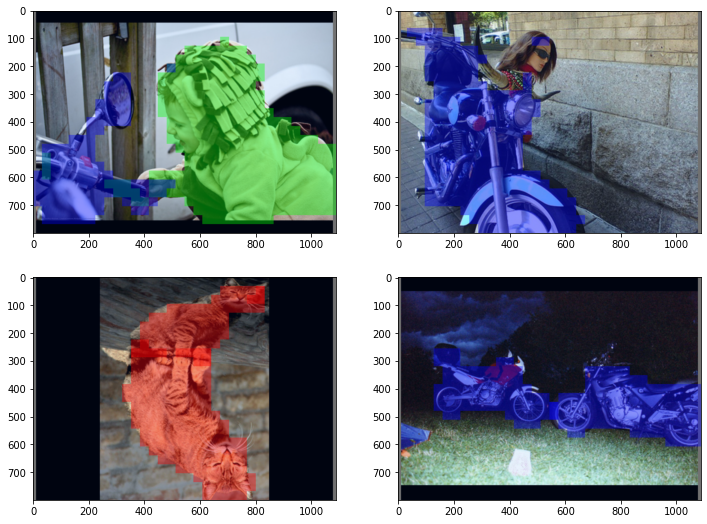

In [ ]:
reload(inference)
i=0
batch_size = 4
inf_subset = Subset(val_dataset, image_samples)
inf_loader = DataLoader(inf_subset, batch_size=batch_size, collate_fn=dataset.collate_fn) 

for image, label, mask, bbox in inf_loader:
    # print(x)
  print(i)
  i+=1 
  with torch.no_grad():
      op = SOLO_model_ckpt.forward(image, eval=True)
      categ_op, mask_op = op
      inference.plot_masked_images(SOLO_model_ckpt, categ_op, mask_op, image)
      plt.show()
  if i==4:
    break

## Discussion

#### Implementation Details

We have used 80% of the data as training data and remaining 20% of the data for validation purposes. The loss function used consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

For training we have used SGD optimizer with a weight decay of ```1e-4``` and a momentum of ```0.9``` is used. For a batch size of ```16```, an initial learning rate of ```0.01``` is used and we have scaled it appropriately to account for variable batch size by using a multiplier of $batch\_size/16$. Overall the training is done for ```36``` epochs, reducing the learning rate by a factor of ```10``` at epochs ```27``` and ```33``` using MultiStepLR from the the ```torch.optim``` lr schedulers package.

#### Challenges and Improvements

The color coding for bounding boxes and masks is as follows:


*   Red : Animal
*   Blue : Vehicle
*   Green : Person




**Interesting Observations**:


By visualizing the images of the dataset we observed that in the dataset for category Animal there are mostly cat images and very few images of horse, bird or duck. 
In the original image if there are any reflections of the actual object then that are also labeled by the model as well. It remains a question of model design and task specifics whether the reflections should be disregarded by the model or not. For example, for the use case of autonomous driving a reflection of a person in a puddle of water can be ignored, but on the other hand people in mirror selfies need to be captured. So, this depends on how the requirements of the problem statement regarding the task are provided and model design.

**Challenges**

Images with multiple objects belonging to the same class close by are masked together instead of separate masks for separate instances. Also, sometimes images with multiple objects with different classes have overlapping masks instead of separate masks. However, the latter issue is less common.

**Improvements and Further Enhancements**

To quantitatively analyze the performance of SOLO for mask prediction, we can perform an error analysis by replacing the predicted masks with ground-truth value.  For each predicted binary mask, we can compute intersection over union with ground-truth masks, and replace it with the most overlapping ground-truth mask. To improve the performance we can try augmenting the existing data and train for more epochs with more images and check the performance of the model. We also read in the existing SOLO paper that we can enhance performance by using DCN-101 as backbone. In the architecture, we can change a few hyperparameters like using Leaky Rectified Linear Units (Leaky ReLU) over normal ReLU, adding more convolution layers.\
In the way of hyper-parameter tuning we can try training the model with different weights for the focal and dice loss. This may accordingly enhance the mask predictions and the categories that are assigned to each object alleviating some of the above mentioned challenges.

